## CALC log analysis

The following notebook assumes you have downloaded the CALC logs as CSV from [api.data.gov/admin](https://api.data.gov/admin/) and saved them as `logs.csv` in the same directory as this notebook.

In [2]:
import pandas

In [3]:
rows = pandas.read_csv('logs.csv', nrows=None, index_col=False, usecols=[
    'Time',
    'Method',
    'URL',
    'State',
    'Country',
    'City',
    'Status',
    'IP Address',
])

The following step is optional; we're removing identical requests coming from the same IP address. This might not actually be a great idea, especially if multiple actual users are behind the same IP address.

In [4]:
rows.drop_duplicates(subset=['Method', 'URL', 'IP Address'], inplace=True)

del rows['IP Address']

Now we'll filter only successful requests to the `/rates/` endpoint, which is the one used when users click the **Search** button (or initially load the page). We'll also parse the query string and add new columns that represent information about the search criteria.

In [44]:
from urllib.parse import urlparse, parse_qsl

RATES_URL = 'https://api.data.gov/gsa/calc/rates/'
FIELD_DEFAULTS = {
    'Search term': '',
    'Minimum experience': 0,
    'Maximum experience': 45,
    'Education level': '',
    'Worksite': '',
    'Business size': '',
    'Schedule': '',
    'Contract year': 'current',
    'Rows excluded': 0,
}

rates = rows
rates = rates[rates['Method'] == 'GET']
rates = rates[rates['Status'] == 200]
rates = rates[rates['URL'].str.startswith(RATES_URL)]

del rates['Method']
del rates['Status']

rates['Query'] = rates['URL'].apply(
    lambda url: dict(parse_qsl(urlparse(url).query))
)

#del rates['URL']

rates['Search term'] = rates['Query'].apply(
    # We're only getting the first search term; not sure if this is a good idea.
    lambda query: query.get('q', '').split(', ')[0].lower().strip()[:25]
)
rates['Minimum experience'] = rates['Query'].apply(
    lambda query: int(query.get('min_experience', FIELD_DEFAULTS['Minimum experience']))
)
rates['Maximum experience'] = rates['Query'].apply(
    lambda query: int(query.get('max_experience', FIELD_DEFAULTS['Maximum experience']))
)
rates['Education level'] = rates['Query'].apply(
    lambda query: query.get('education', '')
)
rates['Worksite'] = rates['Query'].apply(
    lambda query: query.get('site', '')
)
rates['Business size'] = rates['Query'].apply(
    lambda query: query.get('business_size', '')
)
rates['Schedule'] = rates['Query'].apply(
    lambda query: query.get('schedule', '')
)
rates['Contract year'] = rates['Query'].apply(
    lambda query: query.get('contract-year', FIELD_DEFAULTS['Contract year'])
)
rates['Rows excluded'] = rates['Query'].apply(
    lambda query: len(query['exclude'].split(',')) if query.get('exclude') else 0
)

del rates['Query']

## Popular search terms

In [6]:
rates['Search term'].value_counts().head(20).to_frame('Number of searches')

,Number of searches
,3633
engineer,1598
subject matter expert,1477
project manager,1345
program manager,1114
senior engineer,737
software engineer,595
consultant,464
systems engineer,444
training specialist,398


## Search customization

In [45]:
total_rates = rates.shape[0]
percentages = {}

for field, default in FIELD_DEFAULTS.items():
    non_default_rates = rates[rates[field] != default].shape[0]
    percentages[field] = int(non_default_rates / total_rates * 100)

pandas.Series(percentages).to_frame('%').sort_values(by='%', ascending=False)

,%
Search term,92
Education level,44
Minimum experience,38
Maximum experience,37
Worksite,25
Business size,19
Rows excluded,15
Schedule,13
Contract year,3


### How many searches had *no* customization, other than search term?

In [51]:
r = rates

for field, default in FIELD_DEFAULTS.items():
    if field == 'Search term':
        continue
    r = r[r[field] == default]

r.shape[0] / total_rates

0.2937215041619609

## Distribution of minimum experience

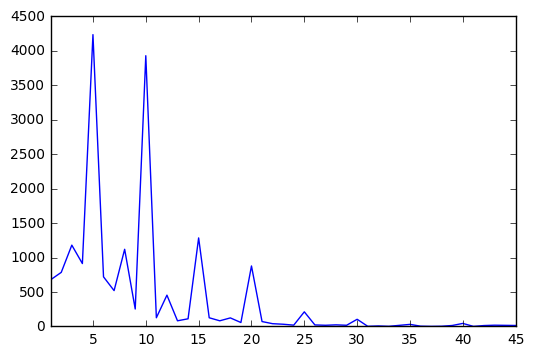

In [43]:
%matplotlib inline

rates[rates['Minimum experience'] > 0]['Minimum experience'].value_counts().sort_index().plot()